# Pricing Cyclone-Catastrophe Risk Bonds Using ICA Dataset

## 1. Introduction

In recent years, catastrophe bonds, or CAT bonds, have gained significant prominence as an essential instrument in the financial and insurance sectors, particularly in regions prone to natural disasters. Cat bonds provide a unique mechanism for transferring significant risks from insurers and reinsurers to capital market investors, thereby offering a vital solution to managing financial exposure to catastrophic events.

CAT bonds operate by allowing insurers to issue bonds through a special purpose vehicle (SPV) that transfers the risk to investors. These bonds are typically linked to specific natural disaster events, such as earthquakes or storms. In the event that a predefined catastrophe occurs, the bond's principal is used to cover the insurance losses, relieving the insurer from the financial burden. Conversely, if no such event occurs, investors receive attractive returns, reflecting the higher yields associated with the elevated risks of CAT bonds.

This report investigates the pricing dynamics of catastrophe (CAT) bonds within the Australian market, utilizing data from the Insurance Council of Australia (ICA) Catastrophe Dataset. In particular, the study applies the pricing methodology proposed by Ma and Ma to model the pricing of cyclone CAT bonds, focusing on trigger mechanisms based on loss metrics.

The remainder of this report is structured as follows: Section 2 outlines the methodology employed for pricing CAT bonds, including the key assumptions and statistical techniques utilized. In Section 3, we present the results of our analysis, highlighting the implications for CAT bond pricing in the Australian market. Finally, Section 4 concludes the report with a summary of key findings and possible discussions which stakeholders in the insurance and capital markets may interested in.

## 2. Methodology

CAT bonds can be treated as defaultable bonds. Thus, their price can be calculated based on the expected discounted returns at maturity. The process can be detailed as follows:

**(i) Modeling the Count Process of Catastrophe Events:** The occurrence of catastrophe events is modeled using a Non-Homogeneous Poisson Process (NHPP). This allows for the rate of occurrence to vary over time, capturing the non-constant nature of catastrophic events.

**(ii) Modeling the Severity of Catastrophe Events:** The severity, or the financial impact, of these events is modeled using heavy-tailed distributions such as log-normal, Burr, Pareto, and Generalized Extreme Value (GEV) distributions. These distributions are chosen for their ability to accurately represent the extreme losses associated with catastrophic events.

**(iii) Simulating Catastrophe Events:** With the fitted models, simulations are performed to generate a large number of possible scenarios for future catastrophe events. Each scenario includes a series of events with varying severities.

**(iv) Calculating Ruin Probability:** For each simulated scenario, the aggregate loss is calculated. The ruin probability is then determined by evaluating the proportion of scenarios where the aggregate loss exceeds the predefined threshold $L_t$, which would trigger a default on the CAT bond.

**(v) Pricing the CAT Bond:** The price of the CAT bond, P, is calculated as the expected discounted return at maturity, accounting for the probability of default. Mathematically, this can be expressed as:
$$P = E\left[ \frac{(1 - I\{L \geq L_t\}) \cdot F}{(1 + r)^n} \right]$$

where:
- $I\{L \geq L_t\}$ is an indicator function that equals 1 if the aggregate loss $ L $ exceeds the threshold $ L_t $ (indicating default) and 0 otherwise.
- $ F $ is the face value of the bond.
- $r$ is the discount rate.
- $n$ is the number of periods until maturity.

## 3. Numerical Analysis

## 3.1) Data Description and Manipulation

The ICA Catastrophe Dataset, managed by the Insurance Council of Australia, provides detailed records of natural hazard events in Australia, including data on event type, location and economic losses. This dataset supports risk assessment, disaster response, and resilience planning, and is available for non-commercial and academic use under specific licensing terms. More information can be accessed at the ICA Data Hub. In this research, we will concentrate on cyclone events only with normalised loss values.

In [474]:
import pandas as pd
df = pd.read_csv("cat.csv")
df.head()

,CAT_Name,CAT_Event_Name,CAT_Event_Start,CAT_Event_Finish,Fin_Year,State,Region_Town,CAT_Description,Location,Type,...,Commercial Property Claims,Commercial motor,Commercial BI Claims,Commercial Other Claims,Commercial Crop Claims,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,CAT233,Christmas Storms,23-Dec-23,03-Jan-24,FY24,"NSW, QLD & VIC",NaN,"Queensland, New South Wales and Victoria impac...",NaN,Flooding,...,"2,377",906,150,55.0,11,NaN,NaN,NaN,NaN,NaN
1,CAT232,TC Jasper and Far North Qld Flooding,10-Dec-23,16-Dec-23,FY24,QLD,NaN,Far North Queensland impacted by severe weathe...,NaN,Flooding,...,607,179,93,13.0,-,NaN,NaN,NaN,NaN,NaN
2,SE231,SE231 Newcastle Hailstorm,23-May-23,23-May-23,FY23,NSW,Newcastle,The Insurance Council of Australia (ICA) has d...,NSW,Hailstorm,...,280,"1,301",15,34.0,-,NaN,NaN,NaN,NaN,NaN
3,SE225,SA River Murray Floods,18-Nov-22,19-Jan-23,FY23,SA,Murray,SA Flooding,SA,Flooding,...,110,7,12,16.0,61,NaN,NaN,NaN,NaN,NaN
4,SE224,Central West NSW Floods,12-Nov-22,05-Dec-22,FY23,NSW,NaN,Severe flooding in Central West NSW. The impac...,NSW,Flooding,...,"1,743",182,81,78.0,380,NaN,NaN,NaN,NaN,NaN


In [475]:
# Manipulating Loss column into numeric
df["NORMALISED LOSS VALUE (2022)"] = df["NORMALISED LOSS VALUE (2022)"].str.replace(',', '')
df["NORMALISED LOSS VALUE (2022)"] = df["NORMALISED LOSS VALUE (2022)"].str.replace('$', '')
df["NORMALISED LOSS VALUE (2022)"] = pd.to_numeric(df["NORMALISED LOSS VALUE (2022)"])

# Manipulating Date column into datetime
def custom_date_parser(date_str):
    date = pd.to_datetime(date_str, format='%d-%b-%y', exact=True)
    if date.year > 2024:
        date = date.replace(year=date.year - 100)
    return date

df['date'] = df['CAT_Event_Start'].apply(custom_date_parser)
df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()

In [476]:
# Filter Cyclone Events
cyclone = df[df["Type"]=="Cyclone"]
cyclone= cyclone[["date","year_month", "NORMALISED LOSS VALUE (2022)"]]
cyclone = cyclone.dropna()
cyclone = cyclone.sort_values(by='date')
cyclone.head()

,date,year_month,NORMALISED LOSS VALUE (2022)
733,1967-01-16,1967-01-01,1.993000e+08
732,1967-01-22,1967-01-01,6.189500e+09
729,1967-02-17,1967-02-01,7.014000e+08
726,1967-03-13,1967-03-01,2.744400e+09
697,1970-01-17,1970-01-01,6.148000e+08


## 3.2) Severity Modeling of Cyclone Events

Text(0, 0.5, 'Count')

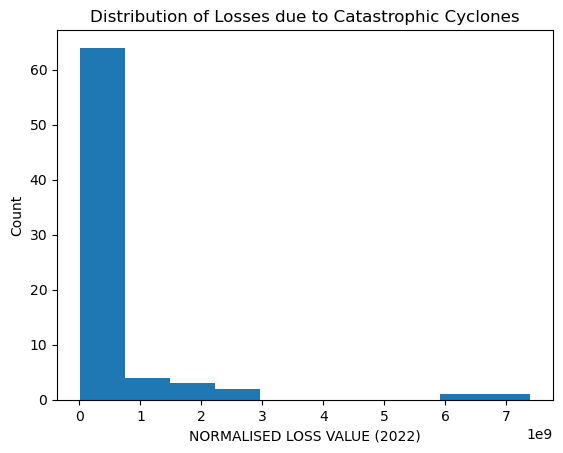

In [479]:
plt.hist(cyclone["NORMALISED LOSS VALUE (2022)"])
plt.title("Distribution of Losses due to Catastrophic Cyclones")
plt.xlabel("NORMALISED LOSS VALUE (2022)")
plt.ylabel("Count")

In [360]:
import scipy.stats as stats
data = np.array(cyclone["NORMALISED LOSS VALUE (2022)"])

# Log-normal Distribution
lognorm_params = stats.lognorm.fit(data, floc=0)

# Burr Distribution
burr_params = stats.burr.fit(data)

# Pareto Distribution
pareto_params = stats.pareto.fit(data, floc=0)

# GEV Distribution
gev_params = stats.genextreme.fit(data)

In [484]:
print("lognormal p-value: ",stats.kstest(data,'lognorm',lognorm_params)[1])
print("burr p-value: ",stats.kstest(data,'burr',burr_params)[1])
print("pareto p-value: ",stats.kstest(data,'pareto',pareto_params)[1])
print("GEV p-value: ",stats.kstest(data,'genextreme',gev_params)[1])

lognormal p-value:  0.6562898673309341
burr p-value:  0.21192485830447327
pareto p-value:  0.0007637747440240039
GEV p-value:  1.150529571684748e-40


From K-S test, Pareto and GEV distributions were rejected to be best-fiiting model as null hypothesis was rejected with p-value less than 0.05. Now, we will measure AICs of log-normal and Burr distributions for best-fitting model selection.

In [489]:
from scipy.stats import lognorm, burr

# AICs lognormal distribution
lognorm_loglik = np.sum(lognorm.logpdf(data, *lognorm_params))
lognorm_k = len(lognorm_params)
lognorm_aic = 2*lognorm_k - 2*lognorm_loglik

# AICs Burr distribution
burr_loglik = np.sum(burr.logpdf(data, *burr_params))
burr_k = len(burr_params)
burr_aic = 2*burr_k - 2*burr_loglik

# Print AIC values
print(f'Lognormal AIC: {lognorm_aic}')
print(f'Burr AIC: {burr_aic}')

Lognormal AIC: 3092.445112504519
Burr AIC: 3101.5373664942704


Since log-normal distribution has lower AIC, log-normal distribution will be selected against Burr for severity distribution of losses. Notice, we assume losses are independently and indentically distributed.

## 3.2) Frequency Modeling of Cyclone Events

To model the frequency of cyclones, we will use a Non-Homogeneous Poisson Process (NHPP) with a periodic intensity function to account for seasonal variations. In modeling the NHPP, we assume that only one event can occur per day, and the counting process begins on January 1, 1967.

In [490]:
# Generating Frequency Data (Daily Based)

df_freq = pd.DataFrame(cyclone["date"])
df_freq["event"] = 1
df_freq['total'] = df_freq['event'].cumsum()
reference_date = pd.to_datetime('1967-01-01')
df_freq['days'] = (df_freq['date'] - reference_date).dt.days
df_freq

,date,event,total,days
733,1967-01-16,1,1,15
732,1967-01-22,1,2,21
729,1967-02-17,1,3,47
726,1967-03-13,1,4,71
697,1970-01-17,1,5,1112
...,...,...,...,...
85,2015-04-27,1,71,17648
73,2016-01-27,1,72,17923
52,2017-03-28,1,73,18349
40,2018-03-14,1,74,18700


In [491]:
times = df_freq['days']
count = df_freq['event']
total = df_freq['total']

/var/folders/cw/xh5jz_hs5j11jl84kkm_7xvh0000gn/T/ipykernel_38158/325578056.py:22: RuntimeWarning:

invalid value encountered in log



Optimal Parameters:
a = 0.0034023584891379084
b = 0.001940017596245386
c = 0.0004959283761768291
d = 0.011572463430955492


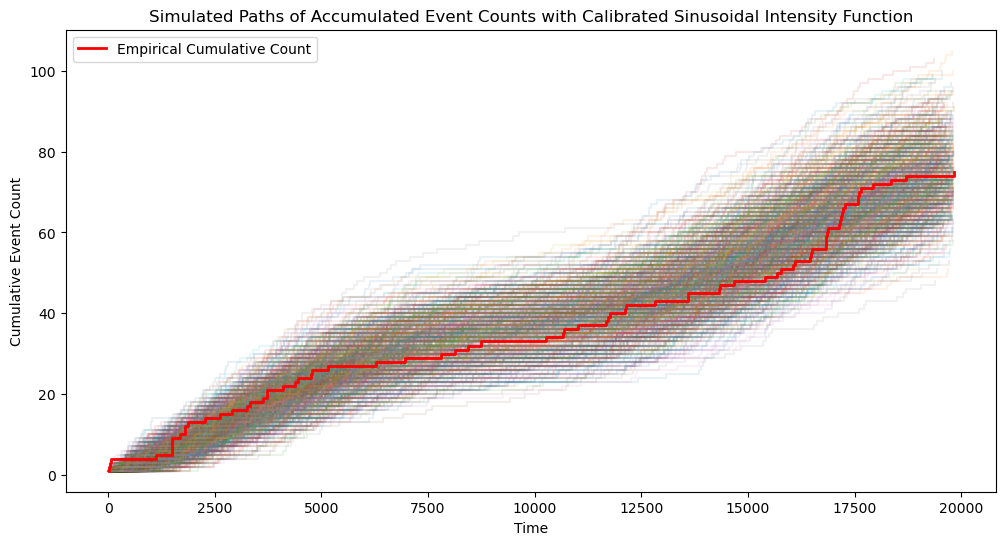

In [493]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Define the sinusoidal intensity function
def sinusoidal_intensity(t, a, b, c, d):
    return a + b * np.sin(c * t + d)

# Define the cumulative intensity function for the sinusoidal model
def cumulative_sinusoidal_intensity(t, a, b, c, d):
    return a * t - (b / c) * np.cos(c * t + d) + (b / c) * np.cos(d)

# Vectorize the sinusoidal intensity function
vectorized_sinusoidal_intensity = np.vectorize(sinusoidal_intensity)
vectorized_cumulative_sinusoidal_intensity = np.vectorize(cumulative_sinusoidal_intensity)

# Define the negative log-likelihood function with stability handling
def negative_log_likelihood(params, event_times):
    a, b, c, d = params
    cum_intensity = vectorized_cumulative_sinusoidal_intensity(event_times, a, b, c, d)
    intensity_values = vectorized_sinusoidal_intensity(event_times, a, b, c, d)
    log_likelihood = -np.sum(np.log(intensity_values + 1e-10)) + cum_intensity[-1]
    return log_likelihood

# Use the provided event times
event_times = np.array(times)

# Initial guesses for parameters a, b, c, and d
initial_params = [1, 0.5, 0.001, 0]

# Perform the optimization to fit the sinusoidal intensity function
result = opt.minimize(negative_log_likelihood, initial_params, args=(event_times,), method='Nelder-Mead')

# Extract the optimal parameters
a_opt, b_opt, c_opt, d_opt = result.x

print("Optimal Parameters:")
print(f"a = {a_opt}")
print(f"b = {b_opt}")
print(f"c = {c_opt}")
print(f"d = {d_opt}")

# Simulation of 100 paths with the calibrated sinusoidal intensity function
def simulate_sinusoidal_events(a, b, c, d, T, max_rate, num_paths):
    simulated_paths = []
    for _ in range(num_paths):
        t = 0
        event_times = []
        while t < T:
            # Generate candidate time from exponential distribution with rate max_rate
            t += np.random.exponential(1 / max_rate)
            if t >= T:
                break
            # Accept the event with probability proportional to the actual intensity
            if np.random.uniform(0, 1) < sinusoidal_intensity(t, a, b, c, d) / max_rate:
                event_times.append(t)
        simulated_paths.append(event_times)
    return simulated_paths

# Define the time horizon and max rate for simulation
T = max(event_times)
max_rate = a_opt + b_opt  # Upper bound for intensity function
num_paths = 1000

# Simulate the events
simulated_paths = simulate_sinusoidal_events(a_opt, b_opt, c_opt, d_opt, T, max_rate, num_paths)

# Plot the accumulated path and original path
plt.figure(figsize=(12, 6))

# Plot the simulated paths
for path in simulated_paths:
    plt.step(path, np.arange(1, len(path) + 1), where='post', alpha=0.1)

# Plot the original empirical cumulative count
empirical_cumulative_counts = np.arange(1, len(event_times) + 1)
plt.step(event_times, empirical_cumulative_counts, where='post', label='Empirical Cumulative Count', color='red', lw=2)

plt.xlabel('Time')
plt.ylabel('Cumulative Event Count')
plt.title('Simulated Paths of Accumulated Event Counts with Calibrated Sinusoidal Intensity Function')
plt.legend()
plt.show()


## 3.3) Price of CAT Bond

Other than frequency and severity of trigger events, threshold levels, interest rates and time to maturity also play crucial roles in CAT bond pricing. For our case study, we will employ RBA's current interest rate (4.35%) as our base interest rate. Also, for simplicity, we will calculate the price of zero-coupon CAT bond with time of maturity of $t$ and trigger of aggreagate loss of $d$.

In [498]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sinusoidal intensity function
def sinusoidal_intensity(t, a, b, c, d):
    return a + b * np.sin(c * t + d)

# Define the function to simulate event times for NHPP with sinusoidal intensity
def simulate_sinusoidal_events(a, b, c, d, T, max_rate, num_paths):
    simulated_paths = []
    for _ in range(num_paths):
        t = 0
        event_times = []
        while t < T:
            # Generate candidate time from exponential distribution with rate max_rate
            t += np.random.exponential(1 / max_rate)
            if t >= T:
                break
            # Accept the event with probability proportional to the actual intensity
            if np.random.uniform(0, 1) < sinusoidal_intensity(t, a, b, c, d) / max_rate:
                event_times.append(t)
        simulated_paths.append(event_times)
    return simulated_paths

# Function to simulate log-normal losses
def simulate_log_normal_losses(mu, sigma, num_losses):
    return np.random.lognormal(mean=mu, sigma=sigma, size=num_losses)

# Function to calculate ruin probability
def calculate_ruin_probability(a, b, c, d, T, max_rate, mu, sigma, D, num_paths):
    ruin_count = 0
    # Simulate the NHPP event times
    simulated_paths = simulate_sinusoidal_events(a, b, c, d, T, max_rate, num_paths)
    for path in simulated_paths:
        # Simulate losses for each event
        losses = simulate_log_normal_losses(mu, sigma, len(path))
        # Calculate the total loss
        total_loss = np.sum(losses)
        # Check if the total loss exceeds the threshold
        if total_loss > D:
            ruin_count += 1
    # Calculate the ruin probability
    ruin_probability = ruin_count / num_paths
    return ruin_probability

# Parameters for the sinusoidal intensity function
a = 0.0034023584891379084
b = 0.001940017596245386
c = 0.0004959283761768291
d = 0.011572463430955492
max_rate = a + b

# Parameters for the log-normal distribution
shape, loc, scale = lognorm_params
mu = np.log(scale)
sigma = shape

# Threshold and number of simulation paths
T = np.linspace(100, 1000, num=20)
D = np.linspace(1000000000, 20000000000, num=20)
num_paths = 5000  # Number of paths to simulate

# Calculate the price
price = np.zeros((len(T),len(D)))
for t in range(20):
    for d in range(20):
        price[t,d] =(1-calculate_ruin_probability(a, b, c, d, T[t], max_rate, mu, sigma, D[d], num_paths))*(1.06**(-T[t]/365))

In [500]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

T = np.linspace(100, 1000, num=20)
D = np.linspace(1000000000, 20000000000, num=20)
T = np.flip(T)
D = np.flip(D)
X = T
Y = D
X, Y = np.meshgrid(X, Y)
Z = price

# Create a surface plot
surface = go.Surface(z=Z, x=X, y=Y)

# Create the layout
layout = go.Layout(
    title='3D Surface Plot of CAT Bond',
    scene=dict(
        xaxis_title='Time to Maturity (in days)',
        yaxis_title='Threshold Level',
        zaxis_title='Price'
    )
)

# Create and plot the figure
fig = go.Figure(data=[surface], layout=layout)
pio.show(fig)


## 4. Key Findings and Discussions

Our analysis reveals that the price of CAT bonds tends to decrease as the threshold decreases and the time to maturity increases. This trend is attributed to the increased probability of default under the specific assumptions we made.

To enhance the accuracy of our model and relax some of the initial assumptions, we recommend using non-independent and identically distributed (non-iid) severity distributions and more sophisticated NHPP intensity functions. Additionally, incorporating stochastic models such as the Cox-Ingersoll-Ross (CIR) and Vasicek models to simulate interest rates can further refine our model and provide a more realistic representation of the factors influencing CAT bond pricing.